
* With the current setup
    * Get the yearly mean for our rough estimate

    * Get the weighted areas, to get energy per grid box




* Can we satisfy the instantaneus demand?
    * Get the instantaneus max demand in a year (Najme)

* Where to put the solar panels?
   * Which are the areas of higher contribution (Selma's cool algorithm)
       * Use top 30 boxes for the local maxima ie, 30 boxes with highest pvpot (mean pvpot or sum pvpot)
   * What makes a place a good place to put solar panels? (Najme)
       *  Radiation, temperature and wind are already accounted in pvpot
       *  ?
       *  Are mountains a good place?
       *  Populated areas?
       *  Beach front
       *  Natural reserves (parks)
       *  Ocean or sea ? can we put them in the mediterranian

* Problem for the future:
    * Max pvpot is at mid day, max consumption is in the evenening
       * What is the maximum difference?
       * How much energy should be stored or commerced(import export)?

### NEXT STEPS (Meeting 08/12/24)
- plot energy per cell for entire year
- Sums for the months
- Sum for entire year

- Where to put the solar panels (see previous comment)

In [2]:
%load_ext autoreload
%autoreload
import tools as tools
import core as core

In [210]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import calendar
import matplotlib.animation

In [4]:
# Open dataset and filter for europe
# range=> [) is open on the right side so +1 to remember
ds = tools.open_dataset(months=range(1,12+1))

mask = xr.open_mfdataset("/home/leonardoq88/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5_landseamask.nc", engine="h5netcdf", chunks={"valid_time": 1e5})

ds_eu = tools.filter_europe_box(ds)

# Filter for Iran
# ds_eu = ds.sel(latitude=slice(40, 24)).sel(longitude=slice(40, 62))

In [5]:
mask_eu = tools.filter_europe_box(mask)

In [6]:
ds_eu

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 8784, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 70kB 2000-01-01 ... 2000-12-31T23...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 141kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

Lets do a rough estimate with the area of europe

In [7]:
# Lets do a rough estimate calculating the overall mean
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time","latitude","longitude"))

In [8]:
# Do the proper computation
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:45933' processes=5 threads=10, memory=753.83 GiB>
Execution time: 26.68527 seconds


In [9]:
ds_eu

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 8784, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 70kB 2000-01-01 ... 2000-12-31T23...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 141kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (12,)
    Months: 12
    Min: 0.03547180816531181
    Mean: 0.13677673041820526
    Max: 0.24583707749843597
    Std: 0.07454156875610352
    


In [11]:
print(f"Each square meter can produce a max of {pvpot.values*237} Watts in January")

Each square meter can produce a max of [11.157536 18.453064 31.556204 44.305676 55.20349  58.263386 52.804558
 45.378643 32.58448  19.455956 11.423204  8.406818] Watts in January


In [12]:
import pint
from pint import UnitRegistry
ureg = UnitRegistry()

# Doing a naive calculation of europe

#AREA:
area_europe = 10.53e6 * (ureg.kilometer * ureg.kilometer)
# '#' compact '~' short 'P' Pretty
print(f"Area Europe: {area_europe:#P}")

# Panel rate for panels ---
panel_rated_ouput = 237 * ureg.watt / (ureg.meter * ureg.meter)
print(f"Panel Rated Output: {panel_rated_ouput:#~P}")

europe_max_solar_energy = np.mean(pvpot.values) * panel_rated_ouput * area_europe
print(f"Max solar energy production europe: {europe_max_solar_energy:#~P.2f}")


europe_max_solar_energy_month = europe_max_solar_energy * (720 * ureg.hour)
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")


Area Europe: 10.53 megameter²
Panel Rated Output: 237.0 W/m²
Max solar energy production europe: 341.34 TW
Max solar energy production europe month Wh: 245.77 h·PW
Max solar energy production europe month J: 884.76 exajoule


In [147]:
# https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_e__custom_13932565/default/table?lang=en
europe_electricity_consumption = 2_824_313.722 * 1e9 * ureg.Wh
print(f"{europe_electricity_consumption.to('gigawatthour'):_}")
print(f"{europe_electricity_consumption.to('gigawatthour'):#~P}")

2_824_313.722 gigawatt_hour
2.824313722 PWh


In [148]:
# Consumption 
europe_electricity_consumption / europe_max_solar_energy_month

<Quantity(11491.8912, 'watt_hour * meter ** 2 / watt / kilometer ** 2 / hour')>

In [149]:
# 84 PW H europe max January over 28 PW H europe year consumption
84.59/2.82

29.996453900709223

## Better calculation with More precise area

In [110]:
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time"))

In [111]:
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:40373' processes=5 threads=10, memory=753.83 GiB>
Execution time: 26.29241 seconds


In [112]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (12, 141, 161)
    Months: 12
    Min: 0.0
    Mean: 0.13677674531936646
    Max: 0.32627660036087036
    Std: 0.0850083976984024
    


In [113]:
pvpot[0]

<xarray.DataArray (latitude: 141, longitude: 161)> Size: 91kB
array([[0.00031222, 0.00031471, 0.00031644, ..., 0.00029615, 0.00029874,
        0.00029938],
       [0.00039874, 0.00040131, 0.00040305, ..., 0.00038027, 0.00038839,
        0.00037046],
       [0.00050565, 0.0005067 , 0.00050641, ..., 0.00046286, 0.0004429 ,
        0.00042279],
       ...,
       [0.12258013, 0.12240249, 0.12198541, ..., 0.12548393, 0.12480054,
        0.12452262],
       [0.12356924, 0.12347526, 0.1234018 , ..., 0.12480268, 0.12513228,
        0.12538747],
       [0.1241347 , 0.12420183, 0.12458853, ..., 0.12378363, 0.12454746,
        0.12511471]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    month      int64 8B 1

In [114]:
mask_pvpot = pvpot * mask_eu["lsm"][0]

In [115]:
mask_pvpot.load()

<xarray.DataArray (month: 12, latitude: 141, longitude: 161)> Size: 1MB
array([[[0.        , 0.        , 0.        , ..., 0.00017976,
         0.00016678, 0.00016234],
        [0.        , 0.        , 0.        , ..., 0.00030158,
         0.00025296, 0.0002301 ],
        [0.        , 0.        , 0.        , ..., 0.00043468,
         0.00040638, 0.00037877],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.01027691,
         0.00964685, 0.00953234],
        [0.        , 0.        , 0.        , ..., 0.01400645,
         0.0118316 , 0.01117807],
        [0.        , 0.        , 0.        , ..., 0.01655709,
         0.01596702, 0.0153904 ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
  * month       (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    valid_time  datetime64[ns] 8B 2000-01-01
    expver      <U4 16B '0001'

Text(0.5, 0.98, 'MegaWatts Hour per month per m^2')

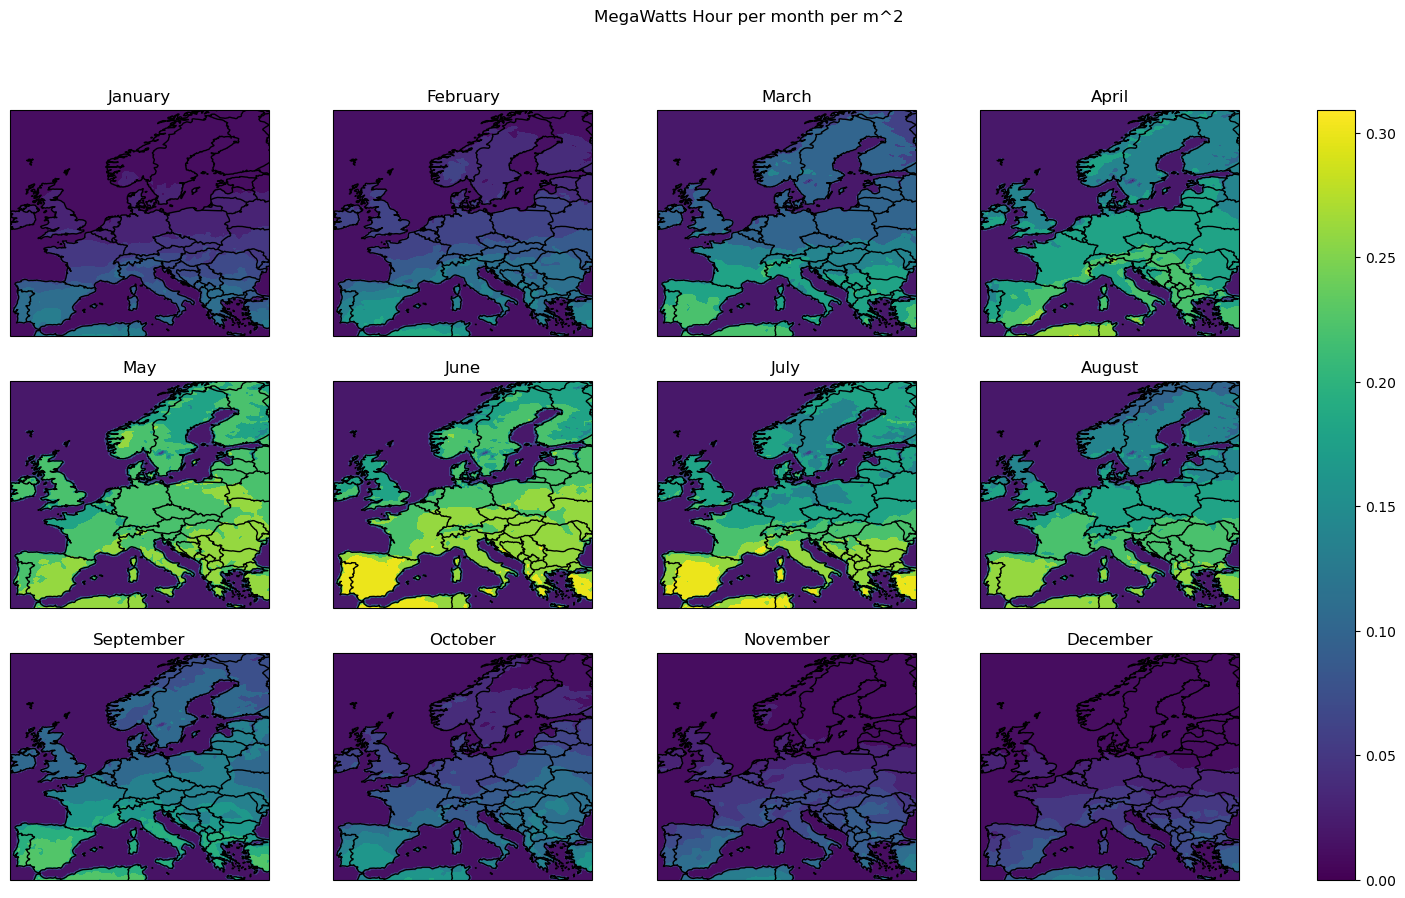

In [116]:
fg, ax = tools.plot_pvpot_per_month(mask_pvpot, 0, mask_pvpot.max())
fg.suptitle("MegaWatts Hour per month per m^2")

In [117]:
import math
def calculate_cell_area(lat1, lat2, lon1, lon2, radius=6371):
    # Convert degrees to radians
    lat1, lat2, lon1, lon2 = map(math.radians, [lat1, lat2, lon1, lon2])
    
    # Calculate the area
    area = radius**2 * abs(math.sin(lat2) - math.sin(lat1)) * abs(lon2 - lon1)
    return area

# Example: Calculate area of a cell
# lat1, lat2 = 3, 3.25  # Latitude bounds
# lon1, lon2 = 5, 5.25  # Longitude bounds
# area = calculate_cell_area(lat1, lat2, lon1, lon2)
# print(f"Area of the cell: {area:.2f} km²")

In [118]:
def grid_cell_area(ds, radius=6371):
    """
    Berechnet die Fläche jeder Gitterzelle basierend auf lat/lon.
    
    Parameters:
        ds (xarray.Dataset): Dataset mit lat/lon-Dimensionen.
        radius (float): Erdradius in Kilometern (Standard: 6371 km).
        
    Returns:
        xarray.DataArray: Flächenwerte für alle Zellen.
    """
    # Sekunden pro Stunde (falls später benötigt)
    sechour = 3600 

    # Extrahiere die Koordinaten für Latitude und Longitude
    lat = ds['latitude'].values
    lon = ds['longitude'].values

    # Berechnung der Bounds (Lat/Lon-Zellenränder)
    lat_bounds = np.concatenate(([lat[0] - (lat[1] - lat[0]) / 2], 
                                  lat[:-1] + np.diff(lat) / 2, 
                                  [lat[-1] + (lat[-1] - lat[-2]) / 2]))
    lon_bounds = np.concatenate(([lon[0] - (lon[1] - lon[0]) / 2], 
                                  lon[:-1] + np.diff(lon) / 2, 
                                  [lon[-1] + (lon[-1] - lon[-2]) / 2]))

    # Flächendifferenzen in Radians
    dlat = np.abs(np.diff(np.sin(np.radians(lat_bounds))))
    dlon = np.abs(np.diff(lon_bounds)) * np.pi / 180

    # Gitter für dlat und dlon erstellen
    dlat_grid, dlon_grid = np.meshgrid(dlat, dlon, indexing="ij")

    # Flächenberechnung für jede Gitterzelle
    cell_areas = radius**2 * dlat_grid * dlon_grid

    # Rückgabe als DataArray
    area_da = xr.DataArray(
        cell_areas,
        coords={"latitude": lat, "longitude": lon},
        dims=["latitude", "longitude"],
        name="cell_area"
    )
    return area_da


In [119]:
ds_eu['cell_area'] = grid_cell_area(ds_eu)
ds_eu['pv_pot'] = mask_pvpot

In [120]:
# Panel rate for panels ---
panel_rated_ouput_per_m2 = 237 # Watts 

ds_eu["energy_potential_per_m2"] = ds_eu["pv_pot"] * panel_rated_ouput_per_m2

ds_eu["energy_potential_per_cell"] = ds_eu["energy_potential_per_m2"] * ds_eu["cell_area"] * 1e6 # Since cell area is in km^2

In [121]:
ds_eu["cell_area"]

<xarray.DataArray 'cell_area' (latitude: 141, longitude: 161)> Size: 182kB
array([[264.30251932, 264.30251932, 264.30251932, ..., 264.30251932,
        264.30251932, 264.30251932],
       [267.46848672, 267.46848672, 267.46848672, ..., 267.46848672,
        267.46848672, 267.46848672],
       [270.62936191, 270.62936191, 270.62936191, ..., 270.62936191,
        270.62936191, 270.62936191],
       ...,
       [629.12312831, 629.12312831, 629.12312831, ..., 629.12312831,
        629.12312831, 629.12312831],
       [631.07517092, 631.07517092, 631.07517092, ..., 631.07517092,
        631.07517092, 631.07517092],
       [633.01519876, 633.01519876, 633.01519876, ..., 633.01519876,
        633.01519876, 633.01519876]])
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0

In [122]:
potential_month = (ds_eu["energy_potential_per_cell"] * 3600 * 24 * 30).sum(axis=(1,2))

In [123]:
potential_month/1e18

<xarray.DataArray 'energy_potential_per_cell' (month: 12)> Size: 96B
array([197.63894679, 305.71703454, 492.19631914, 651.04361718,
       809.7646485 , 855.81057081, 753.98026082, 693.15670175,
       505.43323209, 317.19233412, 191.67015337, 145.17661223])
Coordinates:
    number   int64 8B 0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [124]:
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")

Max solar energy production europe month Wh: 245.77 h·PW
Max solar energy production europe month J: 884.76 exajoule


In [125]:
pot = ds_eu["energy_potential_per_cell"][1].sum(axis=(0,1))
pot


<xarray.DataArray 'energy_potential_per_cell' ()> Size: 8B
array(1.17946387e+14)
Coordinates:
    number   int64 8B 0
    month    int64 8B 2

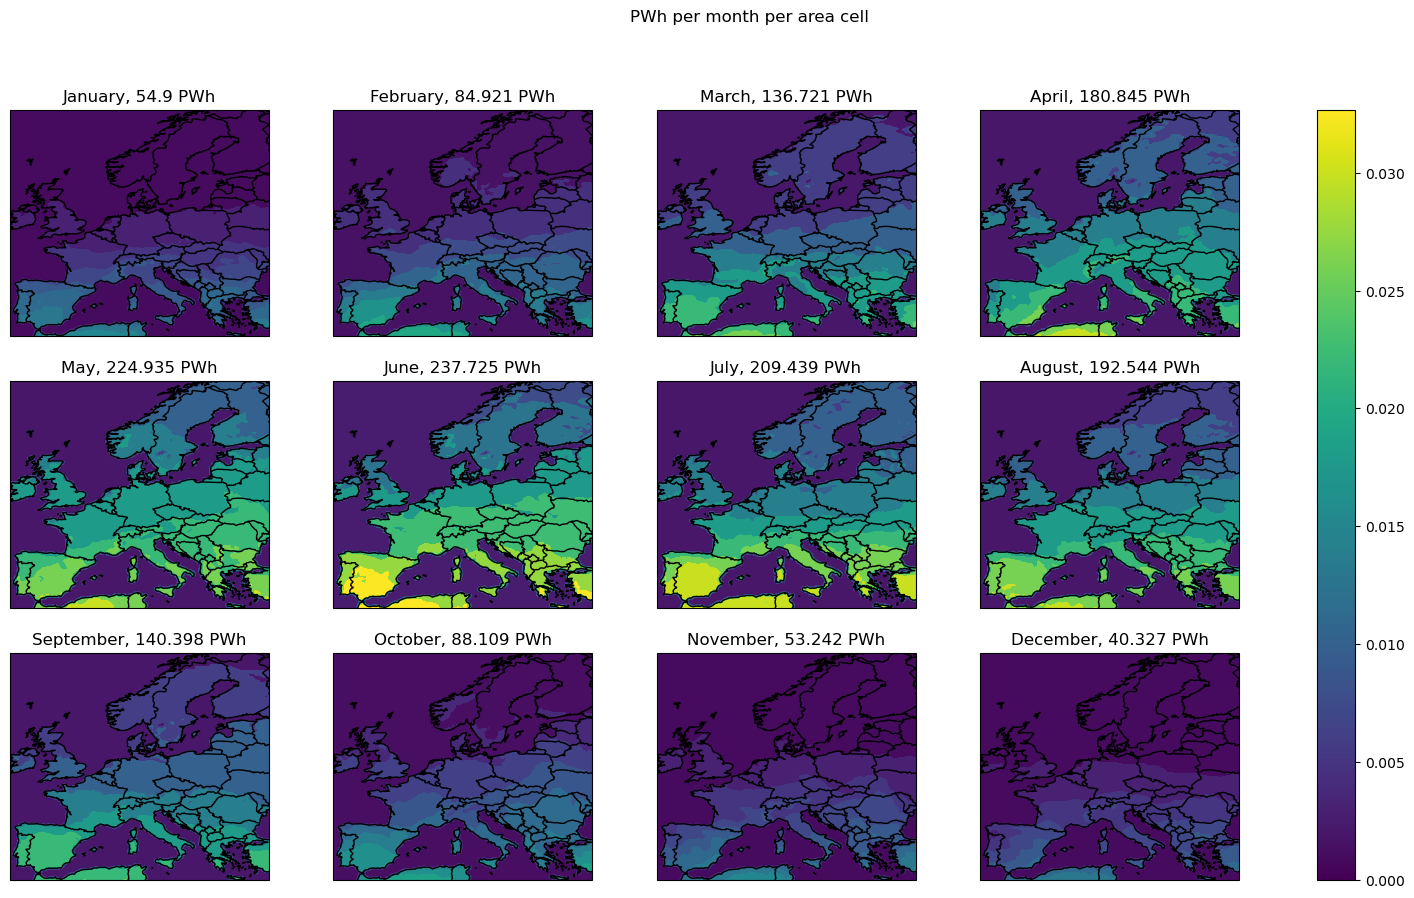

In [126]:
energy_month_per_cell = (ds_eu["energy_potential_per_cell"]*24*30)/1e15
fg, ax = tools.plot_pvpot_per_month(energy_month_per_cell, 0, energy_month_per_cell.max(), datatype = "total_energy")
fg.suptitle("PWh per month per area cell");

In [127]:
year_sum = ((ds_eu["energy_potential_per_cell"]*24*30).sum().values/1e15).round(3)
print(f"Sum for the entire year : , {year_sum:_}, PWh" )

Sum for the entire year : , 1_644.106, PWh


In [128]:
area_ratio = (europe_electricity_consumption.magnitude/1e15)/year_sum
print(f"Electricity consumption in 2022 was: {europe_electricity_consumption.magnitude/1e15} PWh")
print(f"Theoretically, {area_ratio*100:.2f} % of Europe's area could provide enough energy.")

Electricity consumption in 2022 was: 2.824313722 PWh
Theoretically, 0.17 % of Europe's area could provide enough energy.


In [129]:
total_area_square = ds_eu["cell_area"].sum()
print(f"Total area of the square: {total_area_square:_.2f} km\u00b2. {area_ratio*100:.2f} % of that: {total_area_square*area_ratio:_.2f} km\u00b2")

Total area of the square: 10_511_653.74 km². 0.17 % of that: 18_057.36 km²


#### Per month area

In [195]:
# Area per month
monthly_consumption_gwh = np.array([
    239846.01,
    214715.30,
    223847.97,
    200789.41,
    196819.30,
    195747.88,
    204799.53,
    195734.02,
    189367.18,
    191481.59,
    200185.56,
    216137.67
]) # Gigawatt hour
monthly_consumption = monthly_consumption_gwh * 1e9
year_consumption = sum(monthly_consumption)
print(f"{year_consumption}") # Gigas = 10^9
print(f"{year_consumption/1e15:e} TWh") # Petas = 10^15
print(f"Rough area ratio estimate: {(year_consumption)/(monthly_sum.sum()):.4f}")

2469471420000000.0
2.469471e+00 TWh
Rough area ratio estimate: 0.0015


In [174]:
year_consumption/1e15, monthly_sum.sum()/1e15

(2.46947142, 1644.1056753680691)

In [175]:
monthly_sum/1e15

array([ 54.89970744,  84.92139848, 136.72119976, 180.84544922,
       224.93462458, 237.72515856, 209.43896134, 192.54352827,
       140.39812002,  88.1089817 ,  53.24170927,  40.32683673])

In [189]:
## Permonth area required
monthly_potential_watts = ((ds_eu["energy_potential_per_cell"]*24*30).sum(axis=(1,2)).values).round(3)
for month, month_consumption, month_potential in zip(calendar.month_name[1:], monthly_consumption, monthly_potential_watts):
    area = (month_consumption*100/month_potential).round(4)
    print(f"Month: {month:<10} Consumption: {month_consumption/1e15:.2f} TWh Area: {area}%")
    
# area_ratio = (europe_electricity_consumption.magnitude/1e15)/year_sum
# print(f"Electricity consumption in 2022 was: {europe_electricity_consumption.magnitude/1e15} PWh")
# print(f"Theoretically, {area_ratio*100:.2f} % of Europe's area could provide enough energy.")

Month: January    Consumption: 0.24 TWh Area: 0.4369%
Month: February   Consumption: 0.21 TWh Area: 0.2528%
Month: March      Consumption: 0.22 TWh Area: 0.1637%
Month: April      Consumption: 0.20 TWh Area: 0.111%
Month: May        Consumption: 0.20 TWh Area: 0.0875%
Month: June       Consumption: 0.20 TWh Area: 0.0823%
Month: July       Consumption: 0.20 TWh Area: 0.0978%
Month: August     Consumption: 0.20 TWh Area: 0.1017%
Month: September  Consumption: 0.19 TWh Area: 0.1349%
Month: October    Consumption: 0.19 TWh Area: 0.2173%
Month: November   Consumption: 0.20 TWh Area: 0.376%
Month: December   Consumption: 0.22 TWh Area: 0.536%


## Further ideas
- see pvpot changing over the years or decades
- find areas that we could cover with pv panels (to answer the *where*)
- Thinking about the storage problem: maximum differences, power consumption and production curves over different time periods...

### Notes 10.12.2024
- max consumption in a month, max production in a month, so average "monthly buffer" (Naj)
- Sort grid cells top producing to bottom producing and then just sum until you reach what you need (Leo)
- Use ocean mask (Selma)

In [388]:
def get_cells_to_cover_consumption(potential_production, desired_production, percentage_to_cover=1):
    production_cells = []
    energy_coverage = 0
    energy_flat = potential_production.values.flatten()
    mi = np.argsort(energy_flat)[::-1]

    last_printed_percent = 0.0
    for idx in mi:
        lat_idx, lon_idx = np.unravel_index(idx, potential_production.shape)
        energy = energy_flat[idx]
        energy_coverage += energy
        production_cells.append({
            "energy": energy,
            "latitude": ds_eu.latitude.values[lat_idx],
            "longitude": ds_eu.longitude.values[lon_idx],
        })
        if energy_coverage > desired_production*percentage_to_cover:
            break
        else:
            new_coverage_percent = energy_coverage/desired_production
            if (new_coverage_percent - last_printed_percent) > 0.25:
                print(f"Current coverage {energy_coverage:.2e} or {energy_coverage*100/desired_production:.0f}% ")
                last_printed_percent = new_coverage_percent
    print(f"Last coverage {energy_coverage:.2e} or {energy_coverage*100/desired_production:.0f}% ")
    return production_cells


In [389]:
monthly_panel_usage = []
for month, month_consumption, month_potential in zip(calendar.month_name[1:], monthly_consumption, (ds_eu["energy_potential_per_cell"]*24*30)):
    # Dont select cells in Algeria
    month_potential.loc[(month_potential.latitude < 37), (month_potential.longitude <= 15) & (month_potential.longitude >= 0) ] = 0
    month_potential.loc[(month_potential.latitude < 36), (month_potential.longitude < 0) & (month_potential.longitude > -10) ] = 0
    cells = get_cells_to_cover_consumption(month_potential, month_consumption, percentage_to_cover=1.5)
    print(f"Total selected cells {len(cells)}")
    monthly_panel_usage.append(cells)

Current coverage 7.09e+13 or 30% 
Current coverage 1.39e+14 or 58% 
Current coverage 2.07e+14 or 86% 
Current coverage 2.74e+14 or 114% 
Current coverage 3.40e+14 or 142% 
Last coverage 3.67e+14 or 153% 
Total selected cells 27
Current coverage 5.60e+13 or 26% 
Current coverage 1.12e+14 or 52% 
Current coverage 1.67e+14 or 78% 
Current coverage 2.23e+14 or 104% 
Current coverage 2.78e+14 or 129% 
Last coverage 3.33e+14 or 155% 
Total selected cells 18
Current coverage 7.57e+13 or 34% 
Current coverage 1.48e+14 or 66% 
Current coverage 2.19e+14 or 98% 
Current coverage 2.89e+14 or 129% 
Last coverage 3.58e+14 or 160% 
Total selected cells 15
Current coverage 5.34e+13 or 27% 
Current coverage 1.07e+14 or 53% 
Current coverage 1.59e+14 or 79% 
Current coverage 2.12e+14 or 105% 
Current coverage 2.64e+14 or 131% 
Last coverage 3.16e+14 or 157% 
Total selected cells 12
Current coverage 5.76e+13 or 29% 
Current coverage 1.15e+14 or 58% 
Current coverage 1.71e+14 or 87% 
Current coverage 2.28

In [390]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Example: max_coordinates contains the max 10 coordinates and their pvpot values
# max_coordinates = [{'pvpot': value, 'latitude': lat, 'longitude': lon, 'month': month}, ...]

def plot_panel_locations(cells, month=""):
    # Set up the map
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add a base map (using Cartopy's Natural Earth features)
    # Limit we are using: lat 70-35, long: -10,30
    # ax.set_extent([-30, 40, 30, 75], crs=ccrs.PlateCarree())  # Limits for Europe
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    
    # Extract coordinates and values from max_coordinates
    latitudes = [coord['latitude'] for coord in cells]
    longitudes = [coord['longitude'] for coord in cells]
    
    # Plot the coordinates as red points
    ax.scatter(longitudes, latitudes, color='red', marker='s', label='Solar Panels', transform=ccrs.PlateCarree())
    
    ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)
    # Optionally: Label the points with their pvpot values
    # for coord in max_coordinates:
    #     ax.text(coord['longitude'] + 0.5, coord['latitude'], f"{coord['energy']:.2f}", color='red', fontsize=10,
    #             transform=ccrs.PlateCarree())
    
    # Show the plot
    plt.title(f'Panel suggested Locations Europe: {month}')
    plt.legend(loc='upper left')
    # plt.show()

def prepare_panel_locations_plot():
    # Set up the map
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add a base map (using Cartopy's Natural Earth features)
    # ax.set_extent([-30, 40, 30, 75], crs=ccrs.PlateCarree())  # Limits for Europe
    # ax.set_extent([-15, 35, 30, 75], crs=ccrs.PlateCarree())  # Limits for Europe
    ax.set_extent([-11, 31, 34, 71], crs=ccrs.PlateCarree())  # Limits for Europe
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    
    # Extract coordinates and values from max_coordinates
    latitudes = [coord['latitude'] for coord in cells]
    longitudes = [coord['longitude'] for coord in cells]
    
    # Plot the coordinates as red points
    c = ax.contourf(energy_month_per_cell[0].longitude, energy_month_per_cell[0].latitude, energy_month_per_cell[0], vmin=0, vmax=energy_month_per_cell.max())
    l = ax.scatter(longitudes, latitudes, color='red', marker='s', s=13, label='Solar Panels', transform=ccrs.PlateCarree(), zorder=50, edgecolors='black')
    ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)
    # Optionally: Label the points with their pvpot values
    # for coord in max_coordinates:
    #     ax.text(coord['longitude'] + 0.5, coord['latitude'], f"{coord['energy']:.2f}", color='red', fontsize=10,
    #             transform=ccrs.PlateCarree())
    
    # Show the plot
    plt.title(f'Panel suggested Locations Europe: {month}')
    plt.legend(loc='upper left')
    return fig, ax, l, c

def animate(i):
    latitudes = np.array([coord['latitude'] for coord in monthly_panel_usage[i]])
    longitudes = np.array([coord['longitude']-0.1 for coord in monthly_panel_usage[i]])
    energy = sum([cell["energy"] for cell in monthly_panel_usage[i]])/1e15
    # print(latitudes.shape, longitudes.shape)
    # print(f"{energy:.1f}PWh of {monthly_consumption[i]/1e15:.1f}PWh")
    ax.set_title(f'Panel suggested Locations Europe: {calendar.month_name[i+1]}: Generating:{energy:.2f}PWh of {monthly_consumption[i]/1e15:.2f}PWh Required')
    ax.contourf(energy_month_per_cell[i].longitude, energy_month_per_cell[i].latitude, energy_month_per_cell[i], vmin=0, vmax=energy_month_per_cell.max())
    l.set_offsets(np.column_stack((longitudes, latitudes)))  # Update the positions of the scatter points


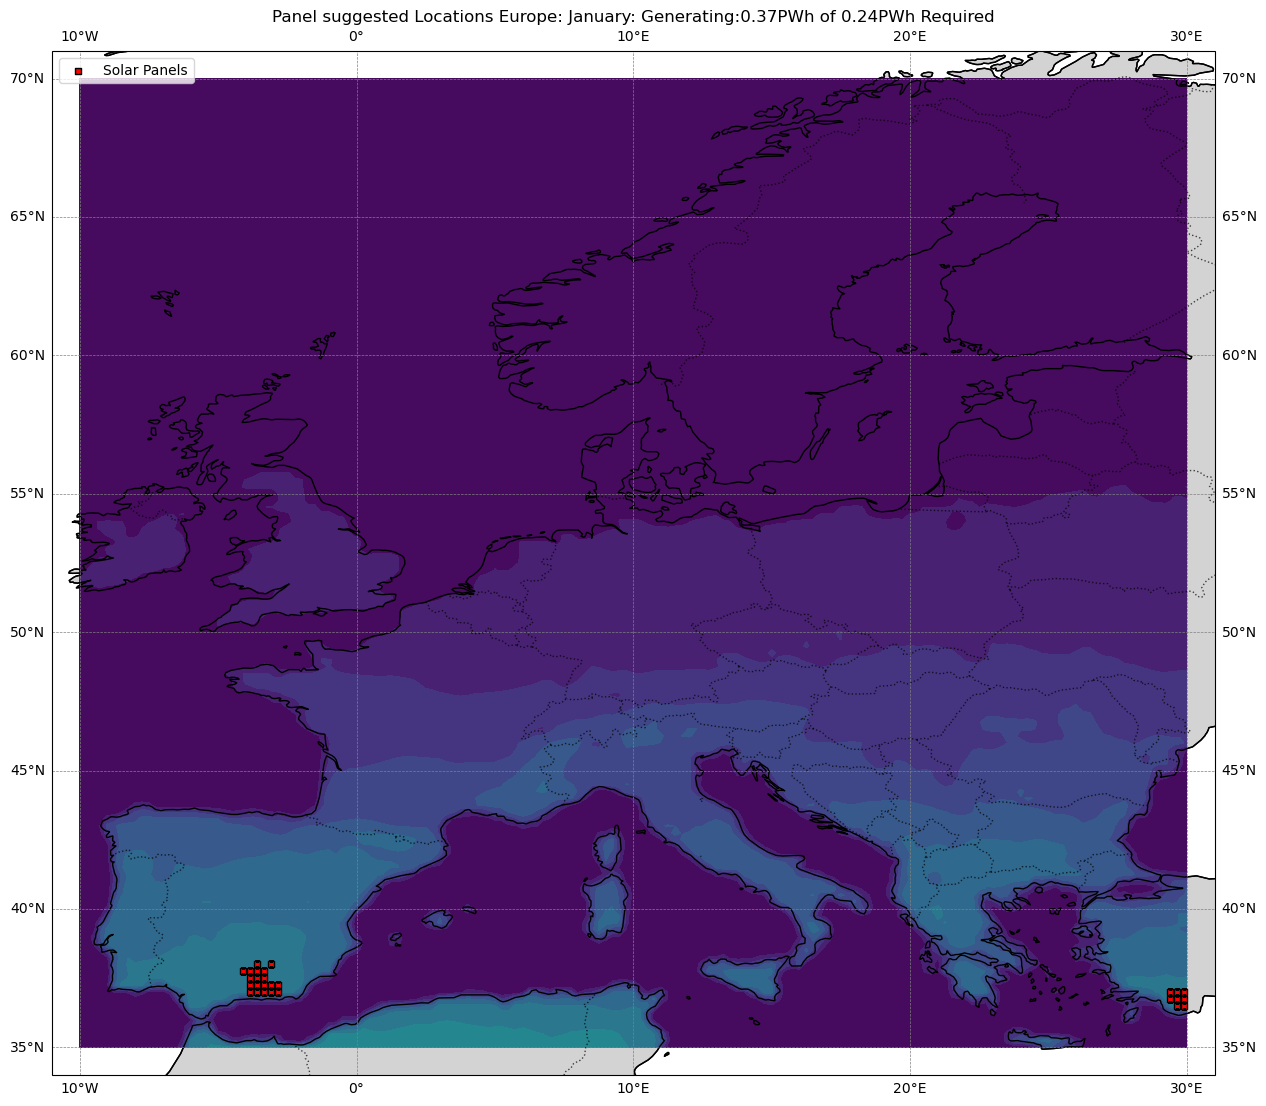

In [391]:
fig, ax,  l, c = prepare_panel_locations_plot()
# Create animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(monthly_panel_usage), interval=1500)

ani.save('sin_animation.gif', writer='pillow', fps=0.5)

# Display animation in Jupyter notebook
from IPython.display import HTML
HTML(ani.to_html5_video())


In [140]:
area_covered = 0
for c in cells:
    area_covered += ds_eu.cell_area.sel(latitude=c["latitude"], longitude=c["longitude"])
area_covered

<xarray.DataArray 'cell_area' ()> Size: 8B
array(6798.8486451)
Coordinates:
    number     int64 8B 0
    latitude   float64 8B 36.75
    longitude  float64 8B 30.0

In [141]:
area_covered/total_area_square

<xarray.DataArray 'cell_area' ()> Size: 8B
array(0.00064679)
Coordinates:
    number     int64 8B 0
    latitude   float64 8B 36.75
    longitude  float64 8B 30.0

In [142]:
area_covered/total_area_square

<xarray.DataArray 'cell_area' ()> Size: 8B
array(0.00064679)
Coordinates:
    number     int64 8B 0
    latitude   float64 8B 36.75
    longitude  float64 8B 30.0

In [143]:
energy_flat = energy_year.where(energy_year > 0).values.flatten()
mi = np.argsort(energy_flat)[::-1]

In [144]:
energy_flat = energy_flat[~np.isnan(energy_flat)]

(array([1675.,  539.,  506., 1120., 1315., 1134.,  849.,  872., 1120.,
        1141.,  881.,  692.,  785.,  590.,  461.,  442.,  365.,  275.,
         183.,   33.]),
 array([1.31697280e+07, 1.35127272e+13, 2.70254411e+13, 4.05381551e+13,
        5.40508691e+13, 6.75635831e+13, 8.10762971e+13, 9.45890111e+13,
        1.08101725e+14, 1.21614439e+14, 1.35127153e+14, 1.48639867e+14,
        1.62152581e+14, 1.75665295e+14, 1.89178009e+14, 2.02690723e+14,
        2.16203437e+14, 2.29716151e+14, 2.43228865e+14, 2.56741579e+14,
        2.70254293e+14]),
 <BarContainer object of 20 artists>)

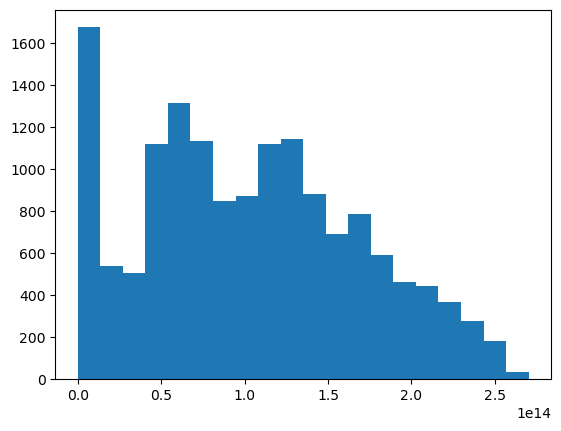

In [145]:
plt.hist(energy_flat, bins=20)

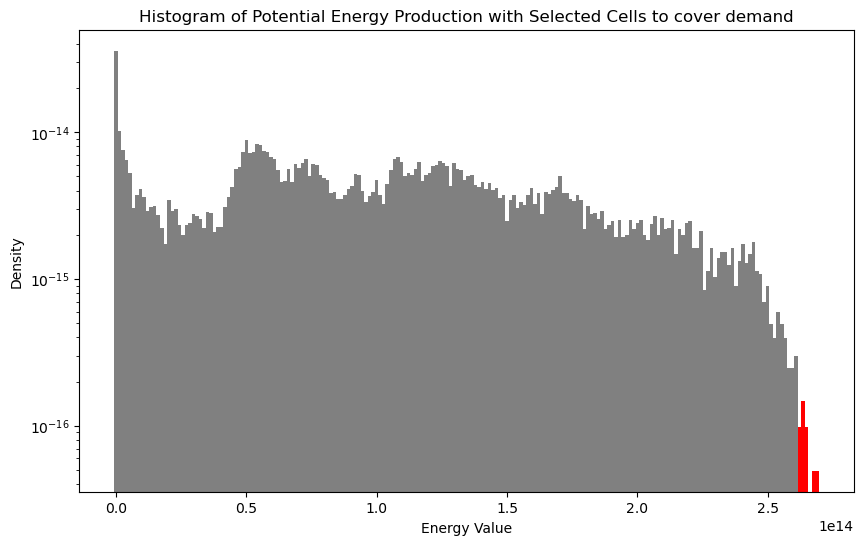

Total selected cells: 11
Total energy produced: 2912140950607229.0


In [146]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_histogram_energy_supply(energy_flat, required_energy):
    # Example: Assuming 'data' is your xarray dataset and 'your_variable' is the energy variable
    # And 'required_energy' is the energy you want to achieve
    
    # 1. Flatten the energy variable into a 1D array
    values = energy_flat

    
    # 2. Sort values from highest to lowest (for selecting the highest producers)
    sorted_values = np.sort(values)[::-1]
    
    # 3. Calculate the cumulative energy and determine how many cells you need to reach the required_energy
    cumulative_energy = np.cumsum(sorted_values)
    
    # Find the index where cumulative energy exceeds or matches the required energy
    selected_cells_count = np.argmax(cumulative_energy >= required_energy) + 1  # +1 to include the cell that meets or exceeds the target
    
    # 4. Create histogram and calculate bin edges and bin counts
    hist_values, bin_edges = np.histogram(values, bins=200, density=True)
    
    # 5. Assign two colors: one for selected cells, another for non-selected cells
    # We will use a mask to mark the selected cells
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    selected_bins = bin_centers >= sorted_values[selected_cells_count-1]  # Select bins based on the cumulative energy
    
    # 6. Create a color mapping for the bins: selected or not
    colors = ['red' if selected else 'gray' for selected in selected_bins]
    
    # 7. Plot the histogram with two colors
    plt.figure(figsize=(10, 6))
    for i in range(len(hist_values)):
        plt.bar(bin_edges[i], hist_values[i], width=np.diff(bin_edges)[i], color=colors[i])
    
    # Add titles and labels
    plt.title('Histogram of Potential Energy Production with Selected Cells to cover demand')
    plt.xlabel('Energy Value')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.show()
    
    # Output the number of cells selected and the total energy produced
    print(f"Total selected cells: {selected_cells_count}")
    print(f"Total energy produced: {cumulative_energy[selected_cells_count-1]}")

plot_histogram_energy_supply(energy_flat, europe_electricity_consumption.magnitude)